In [79]:
### ONLY RUN THIS CELL TO DELETE THE CACHE 
# (reusing cache by same means between runs seems impossible without fudging)
# TODO: update to allow?

! rm -rf ../data/cache

In [80]:
# utils.disk

# Caching utils

import gzip

from diskcache import FanoutCache, Disk, core
from diskcache.core import io, MODE_BINARY
from io import BytesIO

import logging
log = logging.getLogger(__name__)
log.setLevel(logging.DEBUG)

class GzipDisk(Disk):
    def store(self, value, read, key=None):
        """
        Override from base class diskcache.Disk.
        Chunking is due to needing to work on pythons < 2.7.13:
        - Issue #27130: In the "zlib" module, fix handling of large buffers
          (typically 2 or 4 GiB).  Previously, inputs were limited to 2 GiB, and
          compression and decompression operations did not properly handle results of
          2 or 4 GiB.
        :param value: value to convert
        :param bool read: True when value is file-like object
        :return: (size, mode, filename, value) tuple for Cache table
        """
        # pylint: disable=unidiomatic-typecheck
        if type(value) is BytesIO:
            if read:
                value = value.read()
                read = False

            str_io = BytesIO()
            gz_file = gzip.GzipFile(mode='wb', compresslevel=1, fileobj=str_io)

            for offset in range(0, len(value), 2**30):
                gz_file.write(value[offset:offset+2**30])
            gz_file.close()

            value = str_io.getvalue()

        return super(GzipDisk, self).store(value, read)


    def fetch(self, mode, filename, value, read):
        """
        Override from base class diskcache.Disk.
        Chunking is due to needing to work on pythons < 2.7.13:
        - Issue #27130: In the "zlib" module, fix handling of large buffers
          (typically 2 or 4 GiB).  Previously, inputs were limited to 2 GiB, and
          compression and decompression operations did not properly handle results of
          2 or 4 GiB.
        :param int mode: value mode raw, binary, text, or pickle
        :param str filename: filename of corresponding value
        :param value: database value
        :param bool read: when True, return an open file handle
        :return: corresponding Python value
        """
        value = super(GzipDisk, self).fetch(mode, filename, value, read)

        if mode == MODE_BINARY:
            str_io = BytesIO(value)
            gz_file = gzip.GzipFile(mode='rb', fileobj=str_io)
            read_csio = BytesIO()

            while True:
                uncompressed_data = gz_file.read(2**30)
                if uncompressed_data:
                    read_csio.write(uncompressed_data)
                else:
                    break

            value = read_csio.getvalue()

        return value
    

def getCache(scope_str):
    return FanoutCache('../data/cache' + scope_str,
                       disk=GzipDisk,
                       shards=64,
                       timeout=1,
                       size_limit=3e11,
                       # disk_min_file_size=2**20,
                       )

In [81]:
# Conversion from patient coordinates array coordinates, and reverse

import collections

IrcTuple = collections.namedtuple('IrcTuple', ['index', 'row', 'col'])
XyzTuple = collections.namedtuple('XyzTuple', ['x', 'y', 'z'])


def irc2xyz(coord_irc, origin_xyz, vxSize_xyz, direction_a):
    cri_a = np.array(coord_irc)[::-1]
    origin_a = np.array(origin_xyz)
    vxSize_a = np.array(vxSize_xyz)
    coords_xyz = (direction_a @ (cri_a * vxSize_a)) + origin_a
    # coords_xyz = (direction_a @ (idx * vxSize_a)) + origin_a
    return XyzTuple(*coords_xyz)


def xyz2irc(coord_xyz, origin_xyz, vxSize_xyz, direction_a):
    origin_a = np.array(origin_xyz)
    vxSize_a = np.array(vxSize_xyz)
    coord_a = np.array(coord_xyz)
    cri_a = ((coord_a - origin_a) @ np.linalg.inv(direction_a)) / vxSize_a
    cri_a = np.round(cri_a)
    return IrcTuple(int(cri_a[2]), int(cri_a[1]), int(cri_a[0]))


def importstr(module_str, from_=None):
    """
    >>> importstr('os')
    <module 'os' from '.../os.pyc'>
    >>> importstr('math', 'fabs')
    <built-in function fabs>
    """
    if from_ is None and ':' in module_str:
        module_str, from_ = module_str.rsplit(':')

    module = __import__(module_str)
    for sub_str in module_str.split('.')[1:]:
        module = getattr(module, sub_str)

    if from_:
        try:
            return getattr(module, from_)
        except:
            raise ImportError('{}.{}'.format(module_str, from_))
    return module

In [82]:
# dsets.py
# NOTE: can't help but feel this would be far neater using pandas
# Maybe should refactor?

import copy
import csv
import functools
import glob
import math
import os
import random

from collections import namedtuple

import SimpleITK as sitk
import numpy as np

import torch
import torch.cuda
import torch.nn.functional as F
from torch.utils.data import Dataset

raw_cache = getCache('part2ch14_raw')

CandidateInfoTuple = namedtuple(
    'CandidateInfoTuple',
    'isNodule_bool, hasAnnotation_bool, isMal_bool, diameter_mm, series_uid, center_xyz',
)
MaskTuple = namedtuple(
    'MaskTuple',
    'raw_dense_mask, dense_mask, body_mask, air_mask, raw_candidate_mask, candidate_mask, lung_mask, neg_mask, pos_mask',
)

@functools.lru_cache(1)
def getCandidateInfoList(requireOnDisk_bool=True):
    # We construct a set with all series_uids that are present on disk.
    # This will let us use the data, even if we haven't downloaded all of
    # the subsets yet.
    mhd_list = glob.glob('../data/luna/subset*/*.mhd')
    presentOnDisk_set = {os.path.split(p)[-1][:-4] for p in mhd_list}

    candidateInfo_list = []
    with open('../data/luna/segmentation/annotations_with_malignancy.csv', "r") as f:
        for row in list(csv.reader(f))[1:]:
            series_uid = row[0]
            annotationCenter_xyz = tuple([float(x) for x in row[1:4]])
            annotationDiameter_mm = float(row[4])
            isMal_bool = {'False': False, 'True': True}[str(bool(int(float(row[5]))))]

            candidateInfo_list.append(CandidateInfoTuple(True, True, isMal_bool, annotationDiameter_mm, series_uid, annotationCenter_xyz))

    with open('../data/luna/candidates.csv', "r") as f:
        for row in list(csv.reader(f))[1:]:
            series_uid = row[0]

            if series_uid not in presentOnDisk_set and requireOnDisk_bool:
                continue

            isNodule_bool = bool(int(row[4]))
            candidateCenter_xyz = tuple([float(x) for x in row[1:4]])

            if not isNodule_bool:
                candidateInfo_list.append(CandidateInfoTuple(
                    False,
                    False,
                    False,
                    0.0,
                    series_uid,
                    candidateCenter_xyz,
                ))

    candidateInfo_list.sort(reverse=True)
    return candidateInfo_list

@functools.lru_cache(1)
def getCandidateInfoDict(requireOnDisk_bool=True):
    candidateInfo_list = getCandidateInfoList(requireOnDisk_bool)
    candidateInfo_dict = {}

    for candidateInfo_tup in candidateInfo_list:
        candidateInfo_dict.setdefault(candidateInfo_tup.series_uid, []).append(candidateInfo_tup)

    return candidateInfo_dict


class Ct:
    def __init__(self, series_uid):
        mhd_path = glob.glob(
            '../data/luna/subset*/{}.mhd'.format(series_uid)
        )[0]

        ct_mhd = sitk.ReadImage(mhd_path)
        ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)

        # CTs are natively expressed in https://en.wikipedia.org/wiki/Hounsfield_scale
        # HU are scaled oddly, with 0 g/cc (air, approximately) being -1000 and 1 g/cc (water) being 0.
        # The lower bound gets rid of negative density stuff used to indicate out-of-FOV
        # The upper bound nukes any weird hotspots and clamps bone down
        ct_a.clip(-1000, 1000, ct_a)

        self.series_uid = series_uid
        self.hu_a = ct_a

        self.origin_xyz = XyzTuple(*ct_mhd.GetOrigin())
        self.vxSize_xyz = XyzTuple(*ct_mhd.GetSpacing())
        self.direction_a = np.array(ct_mhd.GetDirection()).reshape(3, 3)

    def getRawCandidate(self, center_xyz, width_irc):
        center_irc = xyz2irc(center_xyz, self.origin_xyz, self.vxSize_xyz, self.direction_a)

        slice_list = []
        for axis, center_val in enumerate(center_irc):
            start_ndx = int(round(center_val - width_irc[axis]/2))
            end_ndx = int(start_ndx + width_irc[axis])

            assert center_val >= 0 and center_val < self.hu_a.shape[axis], repr([self.series_uid, center_xyz, self.origin_xyz, self.vxSize_xyz, center_irc, axis])

            if start_ndx < 0:
                # log.warning("Crop outside of CT array: {} {}, center:{} shape:{} width:{}".format(
                #     self.series_uid, center_xyz, center_irc, self.hu_a.shape, width_irc))
                start_ndx = 0
                end_ndx = int(width_irc[axis])

            if end_ndx > self.hu_a.shape[axis]:
                # log.warning("Crop outside of CT array: {} {}, center:{} shape:{} width:{}".format(
                #     self.series_uid, center_xyz, center_irc, self.hu_a.shape, width_irc))
                end_ndx = self.hu_a.shape[axis]
                start_ndx = int(self.hu_a.shape[axis] - width_irc[axis])

            slice_list.append(slice(start_ndx, end_ndx))

        ct_chunk = self.hu_a[tuple(slice_list)]

        return ct_chunk, center_irc


@functools.lru_cache(1, typed=True)
def getCt(series_uid):
    return Ct(series_uid)

@raw_cache.memoize(typed=True)
def getCtRawCandidate(series_uid, center_xyz, width_irc):
    ct = getCt(series_uid)
    ct_chunk, center_irc = ct.getRawCandidate(center_xyz, width_irc)
    return ct_chunk, center_irc

@raw_cache.memoize(typed=True)
def getCtSampleSize(series_uid):
    ct = Ct(series_uid, buildMasks_bool=False)
    return len(ct.negative_indexes)

def getCtAugmentedCandidate(
        augmentation_dict,
        series_uid, center_xyz, width_irc,
        use_cache=True):
    if use_cache:
        ct_chunk, center_irc = getCtRawCandidate(series_uid, center_xyz, width_irc)
    else:
        ct = getCt(series_uid)
        ct_chunk, center_irc = ct.getRawCandidate(center_xyz, width_irc)

    ct_t = torch.tensor(ct_chunk).unsqueeze(0).unsqueeze(0).to(torch.float32)

    transform_t = torch.eye(4)
    # ... <1>

    for i in range(3):
        if 'flip' in augmentation_dict:
            if random.random() > 0.5:
                transform_t[i,i] *= -1

        if 'offset' in augmentation_dict:
            offset_float = augmentation_dict['offset']
            random_float = (random.random() * 2 - 1)
            transform_t[i, 3] = offset_float * random_float

        if 'scale' in augmentation_dict:
            scale_float = augmentation_dict['scale']
            random_float = (random.random() * 2 - 1)
            transform_t[i,i] *= 1.0 + scale_float * random_float


    if 'rotate' in augmentation_dict:
        angle_rad = random.random() * math.pi * 2
        s = math.sin(angle_rad)
        c = math.cos(angle_rad)

        rotation_t = torch.tensor([
            [c, -s, 0, 0],
            [s, c, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1],
        ])

        transform_t @= rotation_t

    affine_t = F.affine_grid(
            transform_t[:3].unsqueeze(0).to(torch.float32),
            ct_t.size(),
            align_corners=False,
        )

    augmented_chunk = F.grid_sample(
            ct_t,
            affine_t,
            padding_mode='border',
            align_corners=False,
        ).to('cpu')

    if 'noise' in augmentation_dict:
        noise_t = torch.randn_like(augmented_chunk)
        noise_t *= augmentation_dict['noise']

        augmented_chunk += noise_t

    return augmented_chunk[0], center_irc


class LunaDataset(Dataset):
    def __init__(self,
                 val_stride=0,
                 isValSet_bool=None,
                 series_uid=None,
                 sortby_str='random',
                 ratio_int=0,
                 augmentation_dict=None,
                 candidateInfo_list=None,
            ):
        self.ratio_int = ratio_int
        self.augmentation_dict = augmentation_dict

        if candidateInfo_list:
            self.candidateInfo_list = copy.copy(candidateInfo_list)
            self.use_cache = False
        else:
            self.candidateInfo_list = copy.copy(getCandidateInfoList())
            self.use_cache = True

        if series_uid:
            self.series_list = [series_uid]
        else:
            self.series_list = sorted(set(candidateInfo_tup.series_uid for candidateInfo_tup in self.candidateInfo_list))

        if isValSet_bool:
            assert val_stride > 0, val_stride
            self.series_list = self.series_list[::val_stride]
            assert self.series_list
        elif val_stride > 0:
            del self.series_list[::val_stride]
            assert self.series_list

        series_set = set(self.series_list)
        self.candidateInfo_list = [x for x in self.candidateInfo_list if x.series_uid in series_set]

        if sortby_str == 'random':
            random.shuffle(self.candidateInfo_list)
        elif sortby_str == 'series_uid':
            self.candidateInfo_list.sort(key=lambda x: (x.series_uid, x.center_xyz))
        elif sortby_str == 'label_and_size':
            pass
        else:
            raise Exception("Unknown sort: " + repr(sortby_str))

        self.neg_list = \
            [nt for nt in self.candidateInfo_list if not nt.isNodule_bool]
        self.pos_list = \
            [nt for nt in self.candidateInfo_list if nt.isNodule_bool]
        self.ben_list = \
            [nt for nt in self.pos_list if not nt.isMal_bool]
        self.mal_list = \
            [nt for nt in self.pos_list if nt.isMal_bool]

        log.info("{!r}: {} {} samples, {} neg, {} pos, {} ratio".format(
            self,
            len(self.candidateInfo_list),
            "validation" if isValSet_bool else "training",
            len(self.neg_list),
            len(self.pos_list),
            '{}:1'.format(self.ratio_int) if self.ratio_int else 'unbalanced'
        ))

    def shuffleSamples(self):
        if self.ratio_int:
            random.shuffle(self.candidateInfo_list)
            random.shuffle(self.neg_list)
            random.shuffle(self.pos_list)
            random.shuffle(self.ben_list)
            random.shuffle(self.mal_list)

    def __len__(self):
        if self.ratio_int:
            return 50000
        else:
            return len(self.candidateInfo_list)

    def __getitem__(self, ndx):
        if self.ratio_int:
            pos_ndx = ndx // (self.ratio_int + 1)

            if ndx % (self.ratio_int + 1):
                neg_ndx = ndx - 1 - pos_ndx
                neg_ndx %= len(self.neg_list)
                candidateInfo_tup = self.neg_list[neg_ndx]
            else:
                pos_ndx %= len(self.pos_list)
                candidateInfo_tup = self.pos_list[pos_ndx]
        else:
            candidateInfo_tup = self.candidateInfo_list[ndx]

        return self.sampleFromCandidateInfo_tup(
            candidateInfo_tup, candidateInfo_tup.isNodule_bool
        )

    def sampleFromCandidateInfo_tup(self, candidateInfo_tup, label_bool):
        width_irc = (32, 48, 48)

        if self.augmentation_dict:
            candidate_t, center_irc = getCtAugmentedCandidate(
                self.augmentation_dict,
                candidateInfo_tup.series_uid,
                candidateInfo_tup.center_xyz,
                width_irc,
                self.use_cache,
            )
        elif self.use_cache:
            candidate_a, center_irc = getCtRawCandidate(
                candidateInfo_tup.series_uid,
                candidateInfo_tup.center_xyz,
                width_irc,
            )
            candidate_t = torch.from_numpy(candidate_a).to(torch.float32)
            candidate_t = candidate_t.unsqueeze(0)
        else:
            ct = getCt(candidateInfo_tup.series_uid)
            candidate_a, center_irc = ct.getRawCandidate(
                candidateInfo_tup.center_xyz,
                width_irc,
            )
            candidate_t = torch.from_numpy(candidate_a).to(torch.float32)
            candidate_t = candidate_t.unsqueeze(0)

        label_t = torch.tensor([False, False], dtype=torch.long)

        if not label_bool:
            label_t[0] = True
            index_t = 0
        else:
            label_t[1] = True
            index_t = 1

        return candidate_t, label_t, index_t, candidateInfo_tup.series_uid, torch.tensor(center_irc)


class MalignantLunaDataset(LunaDataset):
    def __len__(self):
        if self.ratio_int:
            return 100000
        else:
            return len(self.ben_list + self.mal_list)

    def __getitem__(self, ndx):
        if self.ratio_int:
            if ndx % 2 != 0:
                candidateInfo_tup = self.mal_list[(ndx // 2) % len(self.mal_list)]
            elif ndx % 4 == 0:
                candidateInfo_tup = self.ben_list[(ndx // 4) % len(self.ben_list)]
            else:
                candidateInfo_tup = self.neg_list[(ndx // 4) % len(self.neg_list)]
        else:
            if ndx >= len(self.ben_list):
                candidateInfo_tup = self.mal_list[ndx - len(self.ben_list)]
            else:
                candidateInfo_tup = self.ben_list[ndx]

        return self.sampleFromCandidateInfo_tup(
            candidateInfo_tup, candidateInfo_tup.isMal_bool
        )

In [83]:
# Final sample tuple (nodule_t output isn't readable)

LunaDataset()[0]

(tensor([[[[  121.,    71.,    85.,  ...,  -989., -1000.,  -983.],
           [   79.,    37.,     0.,  ...,  -988., -1000., -1000.],
           [   73.,    62.,   -77.,  ...,  -978.,  -982., -1000.],
           ...,
           [ -663.,  -844.,  -968.,  ...,  -542.,  -748.,  -864.],
           [ -697.,  -805.,  -930.,  ...,  -686.,  -793.,  -872.],
           [ -720.,  -750.,  -856.,  ...,  -809.,  -805.,  -822.]],
 
          [[  136.,   129.,   165.,  ...,  -981., -1000., -1000.],
           [  126.,   128.,   146.,  ...,  -997., -1000., -1000.],
           [  122.,   121.,    57.,  ..., -1000., -1000., -1000.],
           ...,
           [ -718.,  -858.,  -942.,  ...,  -757.,  -854.,  -884.],
           [ -780.,  -874.,  -929.,  ...,  -773.,  -849.,  -861.],
           [ -815.,  -859.,  -890.,  ...,  -830.,  -852.,  -841.]],
 
          [[  164.,   166.,   142.,  ...,  -988., -1000., -1000.],
           [  147.,   158.,   117.,  ..., -1000., -1000., -1000.],
           [  155.,   18

## Dataset exploration

In [84]:
"""
We have a few very large candidates, starting at 32 mm, but they rapidly drop off to
half that size. The bulk of the candidates are in the 4 to 10 mm range, and several
hundred don’t have size information at all.
"""

candidateInfo_list = getCandidateInfoList(requireOnDisk_bool=False)
positiveInfo_list = [x for x in candidateInfo_list if x[0]]
diameter_list = [x[1] for x in positiveInfo_list]

for i in range(0, len(diameter_list), 100):
    print('{:4} {:4.1f} mm'.format(i, diameter_list[i]))

   0  1.0 mm
 100  1.0 mm
 200  1.0 mm
 300  1.0 mm
 400  1.0 mm
 500  1.0 mm
 600  1.0 mm
 700  1.0 mm
 800  1.0 mm
 900  1.0 mm
1000  1.0 mm
1100  1.0 mm


In [85]:
# Data visualisation helpers (vis.py)

clim=(-1000.0, 300)

def findPositiveSamples(start_ndx=0, limit=100):
    ds = LunaDataset(sortby_str='label_and_size')

    positiveSample_list = []
    for sample_tup in ds.candidateInfo_list:
        if sample_tup.isNodule_bool:
            print(len(positiveSample_list), sample_tup)
            positiveSample_list.append(sample_tup)

        if len(positiveSample_list) >= limit:
            break

    return positiveSample_list

def showCandidate(series_uid, batch_ndx=None, **kwargs):
    ds = LunaDataset(series_uid=series_uid, **kwargs)
    pos_list = [i for i, x in enumerate(ds.candidateInfo_list) if x.isNodule_bool]

    if batch_ndx is None:
        if pos_list:
            batch_ndx = pos_list[0]
        else:
            print("Warning: no positive samples found; using first negative sample.")
            batch_ndx = 0

    ct = Ct(series_uid)

    ct_t, pos_t, _, series_uid, center_irc = ds[batch_ndx]
    ct_a = ct_t[0].numpy()
    print(ct_a)

    fig = plt.figure(figsize=(30, 50))

    group_list = [
        [9, 11, 13],
        [15, 16, 17],
        [19, 21, 23],
    ]

    subplot = fig.add_subplot(len(group_list) + 2, 3, 1)
    subplot.set_title('index {}'.format(int(center_irc[0])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.hu_a[int(center_irc[0])], clim=clim, cmap='gray')

    subplot = fig.add_subplot(len(group_list) + 2, 3, 2)
    subplot.set_title('row {}'.format(int(center_irc[1])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.hu_a[:,int(center_irc[1])], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 3)
    subplot.set_title('col {}'.format(int(center_irc[2])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.hu_a[:,:,int(center_irc[2])], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 4)
    subplot.set_title('index {}'.format(int(center_irc[0])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[ct_a.shape[0]//2], clim=clim, cmap='gray')

    subplot = fig.add_subplot(len(group_list) + 2, 3, 5)
    subplot.set_title('row {}'.format(int(center_irc[1])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[:,ct_a.shape[1]//2], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 6)
    subplot.set_title('col {}'.format(int(center_irc[2])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[:,:,ct_a.shape[2]//2], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    for row, index_list in enumerate(group_list):
        for col, index in enumerate(index_list):
            subplot = fig.add_subplot(len(group_list) + 2, 3, row * 3 + col + 7)
            subplot.set_title('slice {}'.format(index), fontsize=30)
            for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
                label.set_fontsize(20)
            plt.imshow(ct_a[index], clim=clim, cmap='gray')


    print(series_uid, batch_ndx, bool(pos_t[0]), pos_list)



0 CandidateInfoTuple(isNodule_bool=True, hasAnnotation_bool=True, isMal_bool=True, diameter_mm=32.27003025, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', center_xyz=(67.82725575, 85.37992457, -109.74672379999998))
1 CandidateInfoTuple(isNodule_bool=True, hasAnnotation_bool=True, isMal_bool=True, diameter_mm=30.61040636, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331256326754121315800', center_xyz=(47.67105722, 37.64251989, -99.89039388))
2 CandidateInfoTuple(isNodule_bool=True, hasAnnotation_bool=True, isMal_bool=True, diameter_mm=27.44242293, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251347598519939390311', center_xyz=(-46.94966448, 72.63645381, -95.64452131))
3 CandidateInfoTuple(isNodule_bool=True, hasAnnotation_bool=True, isMal_bool=True, diameter_mm=27.07544345, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.481278873893653517789960724156', center_xyz=(-103.13251120000001, -5.774672551, -206.3554703))
4 CandidateInfoTuple(is

[[[  81.   82.   96. ...  112.   95.   85.]
  [  88.   85.   86. ...  107.  104.  102.]
  [  68.   87.   84. ...  106.  107.  108.]
  ...
  [  43.   22.   13. ...  -16.  -26.  -38.]
  [  40.   26.   10. ...    5.   -9.  -26.]
  [  42.   29.   -3. ...   54.   34.    6.]]

 [[  90.   85.   90. ...  105.  103.  101.]
  [  80.   86.   91. ...  106.  109.  119.]
  [  46.   76.   84. ...  106.  103.  119.]
  ...
  [  46.   14.   -3. ...  -20.  -30.  -24.]
  [  39.   23.    1. ...  -14.  -23.  -25.]
  [  42.   28.    5. ...   22.    7.  -14.]]

 [[  86.   88.   84. ...   93.   90.   80.]
  [  34.   64.   73. ...  123.  123.  127.]
  [  -7.   37.   57. ...  122.  116.  124.]
  ...
  [  39.   11.   12. ...   -1.  -11.   -2.]
  [  55.   33.   25. ...  -11.  -16.   -8.]
  [  59.   40.   23. ...   -3.  -17.  -21.]]

 ...

 [[-561. -594. -714. ... -836. -815. -805.]
  [-601. -610. -751. ... -817. -805. -800.]
  [-669. -707. -806. ... -801. -795. -799.]
  ...
  [-153. -256. -379. ... -687. -728. -78

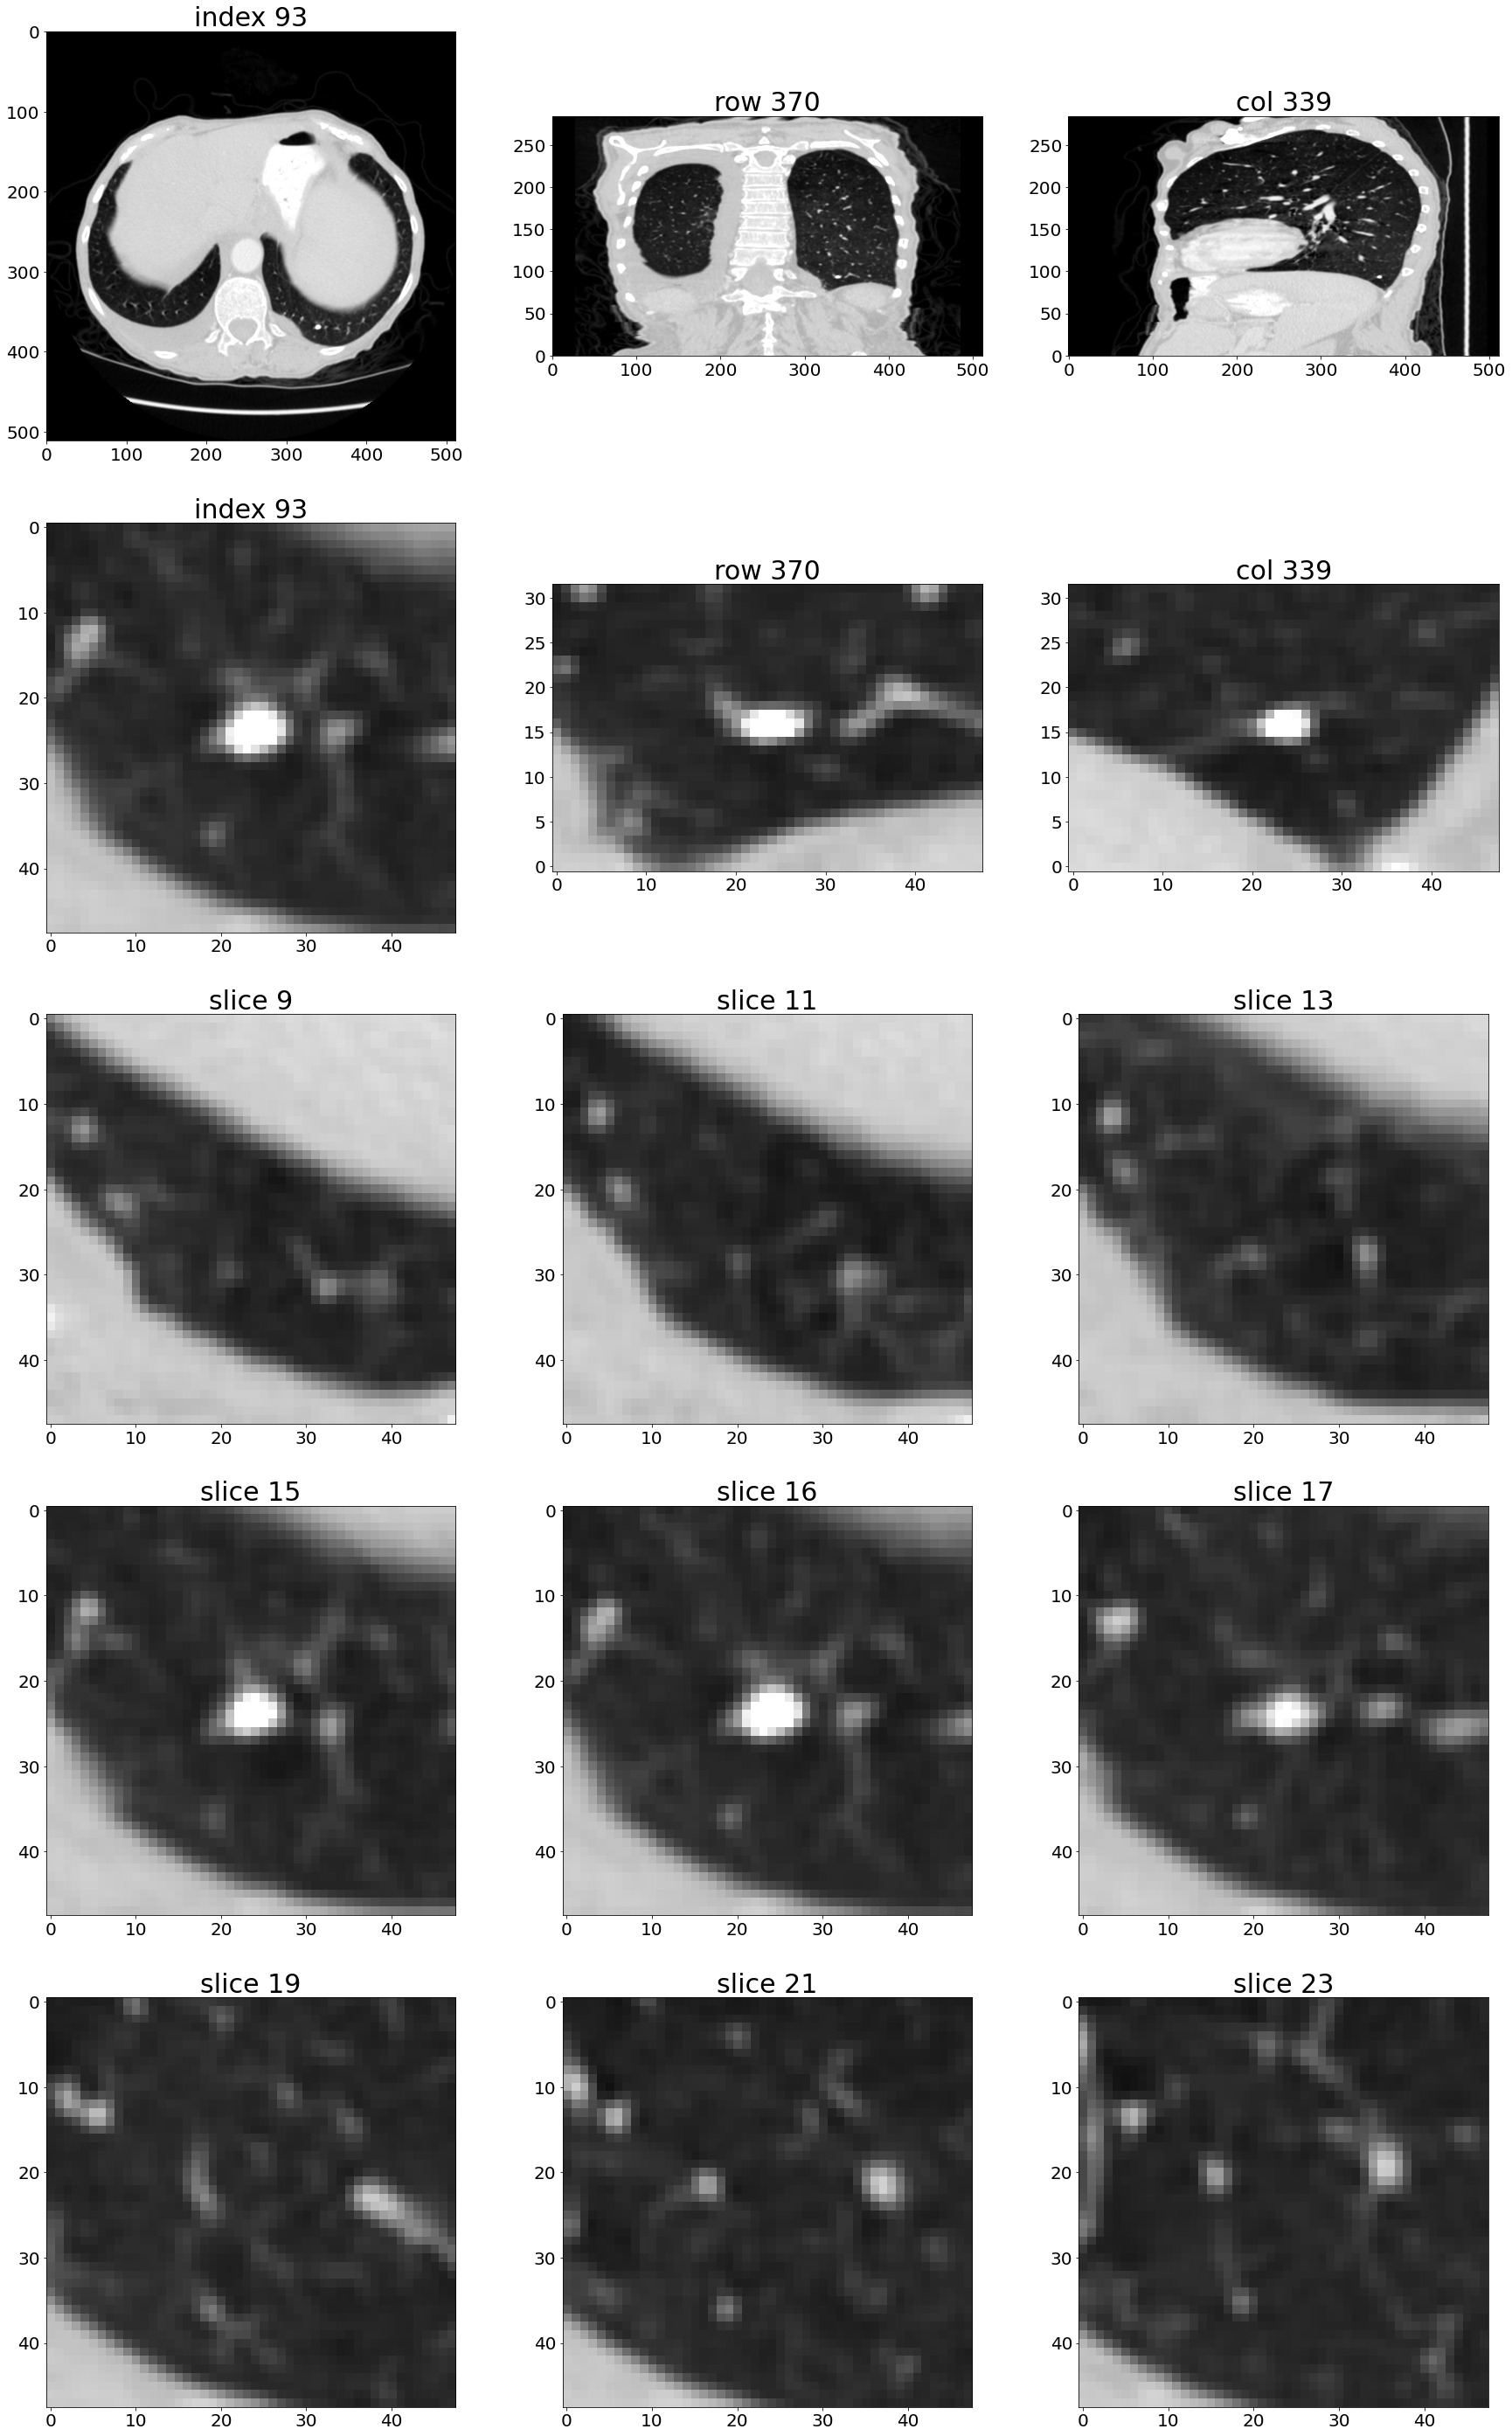

In [86]:
import matplotlib.pyplot as plt

%matplotlib inline
positiveSample_list = findPositiveSamples()

print(f"positiveSample_list: {positiveSample_list}")
series_uid = positiveSample_list[11][4]
print(f"Chosen series_uid: {series_uid}")
showCandidate(series_uid)

In [87]:
import time

ds = LunaDataset(ratio_int=1) # Restrict to limited examples for sake of training time

### Not-so-quick chapter exercise - impact of caching

In [88]:
# ds_len = len(ds)

# item_count = 0

# start_time = time.time()

# for item in ds:
#     example = item
#     item_count += 1
#     if item_count % 100 == 0:
#         print(f"Seen {item_count}/{ds_len} items.")

# end_time = time.time()

# print(f"First iteration took {round(end_time - start_time, 2)} seconds.")

# item_count = 0

# start_time = time.time()

# for item in ds:
#     example = item
#     item_count +=1
#     if item_count % 100 == 0:
#         print(f"Seen {item_count}/{ds_len} items.")

# end_time = time.time()

# print(f"Second iteration took {round(end_time - start_time, 2)} seconds, thanks to caching.")

NOTE: you will need to run

```
! rm -rf ../data/cache
```

To delete the cache.

## Training loop and execution

In [89]:
# Logging helper enumerateWithEstimate (from util.util)

def enumerateWithEstimate(
        iter,
        desc_str,
        start_ndx=0,
        print_ndx=4,
        backoff=None,
        iter_len=None,
):
    """
    In terms of behavior, `enumerateWithEstimate` is almost identical
    to the standard `enumerate` (the differences are things like how
    our function returns a generator, while `enumerate` returns a
    specialized `<enumerate object at 0x...>`).
    However, the side effects (logging, specifically) are what make the
    function interesting.
    :param iter: `iter` is the iterable that will be passed into
        `enumerate`. Required.
    :param desc_str: This is a human-readable string that describes
        what the loop is doing. The value is arbitrary, but should be
        kept reasonably short. Things like `"epoch 4 training"` or
        `"deleting temp files"` or similar would all make sense.
    :param start_ndx: This parameter defines how many iterations of the
        loop should be skipped before timing actually starts. Skipping
        a few iterations can be useful if there are startup costs like
        caching that are only paid early on, resulting in a skewed
        average when those early iterations dominate the average time
        per iteration.
        NOTE: Using `start_ndx` to skip some iterations makes the time
        spent performing those iterations not be included in the
        displayed duration. Please account for this if you use the
        displayed duration for anything formal.
        This parameter defaults to `0`.
    :param print_ndx: determines which loop interation that the timing
        logging will start on. The intent is that we don't start
        logging until we've given the loop a few iterations to let the
        average time-per-iteration a chance to stablize a bit. We
        require that `print_ndx` not be less than `start_ndx` times
        `backoff`, since `start_ndx` greater than `0` implies that the
        early N iterations are unstable from a timing perspective.
        `print_ndx` defaults to `4`.
    :param backoff: This is used to how many iterations to skip before
        logging again. Frequent logging is less interesting later on,
        so by default we double the gap between logging messages each
        time after the first.
        `backoff` defaults to `2` unless iter_len is > 1000, in which
        case it defaults to `4`.
    :param iter_len: Since we need to know the number of items to
        estimate when the loop will finish, that can be provided by
        passing in a value for `iter_len`. If a value isn't provided,
        then it will be set by using the value of `len(iter)`.
    :return:
    """
    if iter_len is None:
        iter_len = len(iter)

    if backoff is None:
        backoff = 2
        while backoff ** 7 < iter_len:
            backoff *= 2

    assert backoff >= 2
    while print_ndx < start_ndx * backoff:
        print_ndx *= backoff

    log.warning("{} ----/{}, starting".format(
        desc_str,
        iter_len,
    ))
    start_ts = time.time()
    for (current_ndx, item) in enumerate(iter):
        yield (current_ndx, item)
        if current_ndx == print_ndx:
            # ... <1>
            duration_sec = ((time.time() - start_ts)
                            / (current_ndx - start_ndx + 1)
                            * (iter_len-start_ndx)
                            )

            done_dt = datetime.datetime.fromtimestamp(start_ts + duration_sec)
            done_td = datetime.timedelta(seconds=duration_sec)

            log.info("{} {:-4}/{}, done at {}, {}".format(
                desc_str,
                current_ndx,
                iter_len,
                str(done_dt).rsplit('.', 1)[0],
                str(done_td).rsplit('.', 1)[0],
            ))

            print_ndx *= backoff

        if current_ndx + 1 == start_ndx:
            start_ts = time.time()

    log.warning("{} ----/{}, done at {}".format(
        desc_str,
        iter_len,
        str(datetime.datetime.now()).rsplit('.', 1)[0],
    ))


In [90]:
# Function for running training

def run(app, *argv):
    argv = list(argv)
    argv.insert(0, '--num-workers=4')  # <1>
    log.info("Running: {}({!r}).main()".format(app, argv))
    
    app_cls = app  # <2>
    app_cls(argv).main()
    
    log.info("Finished: {}.{!r}).main()".format(app, argv))

In [91]:
# Training app defintion

from pathlib import Path

# Constants

# Used for computeBatchLoss and logMetrics to index into metrics_t/metrics_a
METRICS_LABEL_NDX=0
METRICS_PRED_NDX=1
METRICS_PRED_P_NDX=2
METRICS_LOSS_NDX=3
METRICS_SIZE = 4

class ClassificationTrainingApp:
    def __init__(self, sys_argv=None):
        if sys_argv is None:
            sys_argv = sys.argv[1:]

        parser = argparse.ArgumentParser()
        parser.add_argument('--batch-size',
            help='Batch size to use for training',
            default=24,
            type=int,
        )
        parser.add_argument('--num-workers',
            help='Number of worker processes for background data loading',
            default=8,
            type=int,
        )
        parser.add_argument('--epochs',
            help='Number of epochs to train for',
            default=1,
            type=int,
        )
        parser.add_argument('--dataset',
            help="What to dataset to feed the model.",
            action='store',
            default='LunaDataset',
        )
        parser.add_argument('--model',
            help="What to model class name to use.",
            action='store',
            default='LunaModel',
        )
        parser.add_argument('--malignant',
            help="Train the model to classify nodules as benign or malignant.",
            action='store_true',
            default=False,
        )
        parser.add_argument('--finetune',
            help="Start finetuning from this model.",
            default='',
        )
        parser.add_argument('--finetune-depth',
            help="Number of blocks (counted from the head) to include in finetuning",
            type=int,
            default=1,
        )
        parser.add_argument('--tb-prefix',
            default='p2ch14',
            help="Data prefix to use for Tensorboard run. Defaults to chapter.",
        )
        parser.add_argument('comment',
            help="Comment suffix for Tensorboard run.",
            nargs='?',
            default='dlwpt',
        )

        self.cli_args = parser.parse_args(sys_argv)
        self.time_str = datetime.datetime.now().strftime('%Y-%m-%d_%H.%M.%S')

        self.trn_writer = None
        self.val_writer = None
        self.totalTrainingSamples_count = 0

        self.augmentation_dict = {}
        if True:
        # if self.cli_args.augmented or self.cli_args.augment_flip:
            self.augmentation_dict['flip'] = True
        # if self.cli_args.augmented or self.cli_args.augment_offset:
            self.augmentation_dict['offset'] = 0.1
        # if self.cli_args.augmented or self.cli_args.augment_scale:
            self.augmentation_dict['scale'] = 0.2
        # if self.cli_args.augmented or self.cli_args.augment_rotate:
            self.augmentation_dict['rotate'] = True
        # if self.cli_args.augmented or self.cli_args.augment_noise:
            self.augmentation_dict['noise'] = 25.0

        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda" if self.use_cuda else "cpu")

        self.model = self.initModel()
        self.optimizer = self.initOptimizer()


    def initModel(self):
        model_cls = LunaModel # MalignantLunaModel for malignancy classifier, LunaModel for nodule classifier
        model = model_cls()

        if self.cli_args.finetune:
            d = torch.load(self.cli_args.finetune, map_location='cpu')
            model_blocks = [
                n for n, subm in model.named_children()
                if len(list(subm.parameters())) > 0
            ]
            finetune_blocks = model_blocks[-self.cli_args.finetune_depth:]
            log.info(f"finetuning from {self.cli_args.finetune}, blocks {' '.join(finetune_blocks)}")
            model.load_state_dict(
                {
                    k: v for k,v in d['model_state'].items()
                    if k.split('.')[0] not in model_blocks[-1]
                },
                strict=False,
            )
            for n, p in model.named_parameters():
                if n.split('.')[0] not in finetune_blocks:
                    p.requires_grad_(False)
        if self.use_cuda:
            log.info("Using CUDA; {} devices.".format(torch.cuda.device_count()))
            if torch.cuda.device_count() > 1:
                model = nn.DataParallel(model)
            model = model.to(self.device)
        return model

    def initOptimizer(self):
        lr = 0.003 if self.cli_args.finetune else 0.001
        return SGD(self.model.parameters(), lr=lr, weight_decay=1e-4)
        #return Adam(self.model.parameters(), lr=3e-4)

    def initTrainDl(self):
        ds_cls = LunaDataset # switch to MalignantLunaDataset for malig classifier, LunaDataset for nodule classifier

        train_ds = ds_cls(
            val_stride=10,
            isValSet_bool=False,
            ratio_int=1,
        )

        batch_size = self.cli_args.batch_size
        if self.use_cuda:
            batch_size *= torch.cuda.device_count()

        train_dl = DataLoader(
            train_ds,
            batch_size=batch_size,
            num_workers=self.cli_args.num_workers,
            pin_memory=self.use_cuda,
        )

        return train_dl

    def initValDl(self):
        ds_cls = LunaDataset # switch to MalignantLunaDataset for malig classifier, LunaDataset for nodule classifier

        val_ds = ds_cls(
            val_stride=10,
            isValSet_bool=True,
        )

        batch_size = self.cli_args.batch_size
        if self.use_cuda:
            batch_size *= torch.cuda.device_count()

        val_dl = DataLoader(
            val_ds,
            batch_size=batch_size,
            num_workers=self.cli_args.num_workers,
            pin_memory=self.use_cuda,
        )

        return val_dl

    def initTensorboardWriters(self):
        if self.trn_writer is None:
            log_dir = os.path.join('runs', self.cli_args.tb_prefix,
                                   self.time_str)

            self.trn_writer = SummaryWriter(
                log_dir=log_dir + '-trn_cls-' + self.cli_args.comment)
            self.val_writer = SummaryWriter(
                log_dir=log_dir + '-val_cls-' + self.cli_args.comment)


    def main(self):
        log.info("Starting {}, {}".format(type(self).__name__, self.cli_args))

        train_dl = self.initTrainDl()
        val_dl = self.initValDl()

        best_score = 0.0
        validation_cadence = 5 if not self.cli_args.finetune else 1
        for epoch_ndx in range(1, self.cli_args.epochs + 1):

            log.info("Epoch {} of {}, {}/{} batches of size {}*{}".format(
                epoch_ndx,
                self.cli_args.epochs,
                len(train_dl),
                len(val_dl),
                self.cli_args.batch_size,
                (torch.cuda.device_count() if self.use_cuda else 1),
            ))

            trnMetrics_t = self.doTraining(epoch_ndx, train_dl)
            self.logMetrics(epoch_ndx, 'trn', trnMetrics_t)

            if epoch_ndx == 1 or epoch_ndx % validation_cadence == 0:
                valMetrics_t = self.doValidation(epoch_ndx, val_dl)
                score = self.logMetrics(epoch_ndx, 'val', valMetrics_t)
                best_score = max(score, best_score)

                # TODO: this 'cls' will need to change for the malignant classifier
                self.saveModel('cls', epoch_ndx, score == best_score)


        if hasattr(self, 'trn_writer'):
            self.trn_writer.close()
            self.val_writer.close()


    def doTraining(self, epoch_ndx, train_dl):
        self.model.train()
        train_dl.dataset.shuffleSamples()
        trnMetrics_g = torch.zeros(
            METRICS_SIZE,
            len(train_dl.dataset),
            device=self.device,
        )

        batch_iter = enumerateWithEstimate(
            train_dl,
            "E{} Training".format(epoch_ndx),
            start_ndx=train_dl.num_workers,
        )
        for batch_ndx, batch_tup in batch_iter:
            self.optimizer.zero_grad()

            loss_var = self.computeBatchLoss(
                batch_ndx,
                batch_tup,
                train_dl.batch_size,
                trnMetrics_g,
                augment=True
            )

            loss_var.backward()
            self.optimizer.step()

        self.totalTrainingSamples_count += len(train_dl.dataset)

        return trnMetrics_g.to('cpu')


    def doValidation(self, epoch_ndx, val_dl):
        with torch.no_grad():
            self.model.eval()
            valMetrics_g = torch.zeros(
                METRICS_SIZE,
                len(val_dl.dataset),
                device=self.device,
            )

            batch_iter = enumerateWithEstimate(
                val_dl,
                "E{} Validation ".format(epoch_ndx),
                start_ndx=val_dl.num_workers,
            )
            for batch_ndx, batch_tup in batch_iter:
                self.computeBatchLoss(
                    batch_ndx,
                    batch_tup,
                    val_dl.batch_size,
                    valMetrics_g,
                    augment=False
                )

        return valMetrics_g.to('cpu')



    def computeBatchLoss(self, batch_ndx, batch_tup, batch_size, metrics_g,
                         augment=True):
        input_t, label_t, index_t, _series_list, _center_list = batch_tup

        input_g = input_t.to(self.device, non_blocking=True)
        label_g = label_t.to(self.device, non_blocking=True)
        index_g = index_t.to(self.device, non_blocking=True)


        if augment:
            input_g = augment3d(input_g)

        logits_g, probability_g = self.model(input_g)

        loss_g = nn.functional.cross_entropy(logits_g, label_g[:, 1],
                                             reduction="none")
        start_ndx = batch_ndx * batch_size
        end_ndx = start_ndx + label_t.size(0)

        _, predLabel_g = torch.max(probability_g, dim=1, keepdim=False,
                                   out=None)

        # log.debug(index_g)

        metrics_g[METRICS_LABEL_NDX, start_ndx:end_ndx] = index_g
        metrics_g[METRICS_PRED_NDX, start_ndx:end_ndx] = predLabel_g
        # metrics_g[METRICS_PRED_N_NDX, start_ndx:end_ndx] = probability_g[:,0]
        metrics_g[METRICS_PRED_P_NDX, start_ndx:end_ndx] = probability_g[:,1]
        # metrics_g[METRICS_PRED_M_NDX, start_ndx:end_ndx] = probability_g[:,2]
        metrics_g[METRICS_LOSS_NDX, start_ndx:end_ndx] = loss_g

        return loss_g.mean()


    def logMetrics(
            self,
            epoch_ndx,
            mode_str,
            metrics_t,
            classificationThreshold=0.5,
    ):
        self.initTensorboardWriters()
        log.info("E{} {}".format(
            epoch_ndx,
            type(self).__name__,
        ))

        if self.cli_args.dataset == 'MalignantLunaDataset':
            pos = 'mal'
            neg = 'ben'
        else:
            pos = 'pos'
            neg = 'neg'


        negLabel_mask = metrics_t[METRICS_LABEL_NDX] == 0
        negPred_mask = metrics_t[METRICS_PRED_NDX] == 0

        posLabel_mask = ~negLabel_mask
        posPred_mask = ~negPred_mask

        # benLabel_mask = metrics_t[METRICS_LABEL_NDX] == 1
        # benPred_mask = metrics_t[METRICS_PRED_NDX] == 1
        #
        # malLabel_mask = metrics_t[METRICS_LABEL_NDX] == 2
        # malPred_mask = metrics_t[METRICS_PRED_NDX] == 2

        # benLabel_mask = ~malLabel_mask & posLabel_mask
        # benPred_mask = ~malPred_mask & posLabel_mask

        neg_count = int(negLabel_mask.sum())
        pos_count = int(posLabel_mask.sum())
        # ben_count = int(benLabel_mask.sum())
        # mal_count = int(malLabel_mask.sum())

        neg_correct = int((negLabel_mask & negPred_mask).sum())
        pos_correct = int((posLabel_mask & posPred_mask).sum())
        # ben_correct = int((benLabel_mask & benPred_mask).sum())
        # mal_correct = int((malLabel_mask & malPred_mask).sum())

        trueNeg_count = neg_correct
        truePos_count = pos_correct

        falsePos_count = neg_count - neg_correct
        falseNeg_count = pos_count - pos_correct

        metrics_dict = {}
        metrics_dict['loss/all'] = metrics_t[METRICS_LOSS_NDX].mean()
        metrics_dict['loss/neg'] = metrics_t[METRICS_LOSS_NDX, negLabel_mask].mean()
        metrics_dict['loss/pos'] = metrics_t[METRICS_LOSS_NDX, posLabel_mask].mean()
        # metrics_dict['loss/ben'] = metrics_t[METRICS_LOSS_NDX, benLabel_mask].mean()
        # metrics_dict['loss/mal'] = metrics_t[METRICS_LOSS_NDX, malLabel_mask].mean()

        metrics_dict['correct/all'] = (pos_correct + neg_correct) / metrics_t.shape[1] * 100
        metrics_dict['correct/neg'] = (neg_correct) / neg_count * 100
        metrics_dict['correct/pos'] = (pos_correct) / pos_count * 100
        # metrics_dict['correct/ben'] = (ben_correct) / ben_count * 100
        # metrics_dict['correct/mal'] = (mal_correct) / mal_count * 100

        precision = metrics_dict['pr/precision'] = \
            truePos_count / np.float64(truePos_count + falsePos_count)
        recall    = metrics_dict['pr/recall'] = \
            truePos_count / np.float64(truePos_count + falseNeg_count)

        metrics_dict['pr/f1_score'] = \
            2 * (precision * recall) / (precision + recall)

        threshold = torch.linspace(1, 0)
        tpr = (metrics_t[None, METRICS_PRED_P_NDX, posLabel_mask] >= threshold[:, None]).sum(1).float() / pos_count
        fpr = (metrics_t[None, METRICS_PRED_P_NDX, negLabel_mask] >= threshold[:, None]).sum(1).float() / neg_count
        fp_diff = fpr[1:]-fpr[:-1]
        tp_avg  = (tpr[1:]+tpr[:-1])/2
        auc = (fp_diff * tp_avg).sum()
        metrics_dict['auc'] = auc

        log.info(
            ("E{} {:8} {loss/all:.4f} loss, "
                 + "{correct/all:-5.1f}% correct, "
                 + "{pr/precision:.4f} precision, "
                 + "{pr/recall:.4f} recall, "
                 + "{pr/f1_score:.4f} f1 score, "
                 + "{auc:.4f} auc"
            ).format(
                epoch_ndx,
                mode_str,
                **metrics_dict,
            )
        )
        log.info(
            ("E{} {:8} {loss/neg:.4f} loss, "
                 + "{correct/neg:-5.1f}% correct ({neg_correct:} of {neg_count:})"
            ).format(
                epoch_ndx,
                mode_str + '_' + neg,
                neg_correct=neg_correct,
                neg_count=neg_count,
                **metrics_dict,
            )
        )
        log.info(
            ("E{} {:8} {loss/pos:.4f} loss, "
                 + "{correct/pos:-5.1f}% correct ({pos_correct:} of {pos_count:})"
            ).format(
                epoch_ndx,
                mode_str + '_' + pos,
                pos_correct=pos_correct,
                pos_count=pos_count,
                **metrics_dict,
            )
        )
        # log.info(
        #     ("E{} {:8} {loss/ben:.4f} loss, "
        #          + "{correct/ben:-5.1f}% correct ({ben_correct:} of {ben_count:})"
        #     ).format(
        #         epoch_ndx,
        #         mode_str + '_ben',
        #         ben_correct=ben_correct,
        #         ben_count=ben_count,
        #         **metrics_dict,
        #     )
        # )
        # log.info(
        #     ("E{} {:8} {loss/mal:.4f} loss, "
        #          + "{correct/mal:-5.1f}% correct ({mal_correct:} of {mal_count:})"
        #     ).format(
        #         epoch_ndx,
        #         mode_str + '_mal',
        #         mal_correct=mal_correct,
        #         mal_count=mal_count,
        #         **metrics_dict,
        #     )
        # )
        writer = getattr(self, mode_str + '_writer')

        for key, value in metrics_dict.items():
            key = key.replace('pos', pos)
            key = key.replace('neg', neg)
            writer.add_scalar(key, value, self.totalTrainingSamples_count)

        fig = pyplot.figure()
        pyplot.plot(fpr, tpr)
        writer.add_figure('roc', fig, self.totalTrainingSamples_count)

        writer.add_scalar('auc', auc, self.totalTrainingSamples_count)
# # tag::logMetrics_writer_prcurve[]
#        writer.add_pr_curve(
#            'pr',
#            metrics_t[METRICS_LABEL_NDX],
#            metrics_t[METRICS_PRED_P_NDX],
#            self.totalTrainingSamples_count,
#        )
# # end::logMetrics_writer_prcurve[]

        bins = np.linspace(0, 1)

        writer.add_histogram(
            'label_neg',
            metrics_t[METRICS_PRED_P_NDX, negLabel_mask],
            self.totalTrainingSamples_count,
            bins=bins
        )
        writer.add_histogram(
            'label_pos',
            metrics_t[METRICS_PRED_P_NDX, posLabel_mask],
            self.totalTrainingSamples_count,
            bins=bins
        )

        if not self.cli_args.malignant:
            score = metrics_dict['pr/f1_score']
        else:
            score = metrics_dict['auc']

        return score

    def saveModel(self, type_str, epoch_ndx, isBest=False):
        file_path = os.path.join(
            'data-unversioned',
            'part2',
            'models',
            self.cli_args.tb_prefix,
            '{}_{}_{}.{}.state'.format(
                type_str,
                self.time_str,
                self.cli_args.comment,
                self.totalTrainingSamples_count,
            )
        )

        os.makedirs(os.path.dirname(file_path), mode=0o755, exist_ok=True)

        model = self.model
        if isinstance(model, torch.nn.DataParallel):
            model = model.module

        state = {
            'model_state': model.state_dict(),
            'model_name': type(model).__name__,
            'optimizer_state' : self.optimizer.state_dict(),
            'optimizer_name': type(self.optimizer).__name__,
            'epoch': epoch_ndx,
            'totalTrainingSamples_count': self.totalTrainingSamples_count,
        }
        torch.save(state, file_path)

        log.debug("Saved model params to {}".format(file_path))

        if isBest:
            best_path = os.path.join(
                'data-unversioned',
                'part2',
                'models',
                self.cli_args.tb_prefix,
                '{}_{}_{}.{}.state'.format(
                    type_str,
                    self.time_str,
                    self.cli_args.comment,
                    'best',
                )
            )
            shutil.copyfile(file_path, best_path)

            log.debug("Saved model params to {}".format(best_path))

        with open(file_path, 'rb') as f:
            log.info("SHA1: " + hashlib.sha1(f.read()).hexdigest())



In [92]:
# Module (utilising pre-defined block)

# Model definition

import random
import torch.nn as nn

def augment3d(inp):
    transform_t = torch.eye(4, dtype=torch.float32)
    for i in range(3):
        if True: #'flip' in augmentation_dict:
            if random.random() > 0.5:
                transform_t[i,i] *= -1
        if True: #'offset' in augmentation_dict:
            offset_float = 0.1
            random_float = (random.random() * 2 - 1)
            transform_t[3,i] = offset_float * random_float
    if True:
        angle_rad = random.random() * np.pi * 2
        s = np.sin(angle_rad)
        c = np.cos(angle_rad)

        rotation_t = torch.tensor([
            [c, -s, 0, 0],
            [s, c, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1],
        ], dtype=torch.float32)

        transform_t @= rotation_t
    #print(inp.shape, transform_t[:3].unsqueeze(0).expand(inp.size(0), -1, -1).shape)
    affine_t = torch.nn.functional.affine_grid(
            transform_t[:3].unsqueeze(0).expand(inp.size(0), -1, -1).cuda(),
            inp.shape,
            align_corners=False,
        )

    augmented_chunk = torch.nn.functional.grid_sample(
            inp,
            affine_t,
            padding_mode='border',
            align_corners=False,
        )
    if False: #'noise' in augmentation_dict:
        noise_t = torch.randn_like(augmented_chunk)
        noise_t *= augmentation_dict['noise']

        augmented_chunk += noise_t
    return augmented_chunk


class LunaModel(nn.Module):
    def __init__(self, in_channels=1, conv_channels=8):
        super().__init__()

        self.tail_batchnorm = nn.BatchNorm3d(1)

        self.block1 = LunaBlock(in_channels, conv_channels)
        self.block2 = LunaBlock(conv_channels, conv_channels * 2)
        self.block3 = LunaBlock(conv_channels * 2, conv_channels * 4)
        self.block4 = LunaBlock(conv_channels * 4, conv_channels * 8)

        # self.head_linear = nn.Linear(1152, 2)
        self.head_linear = nn.Linear(1152, 2)
        self.head_activation = nn.Softmax(dim=1)

        self._init_weights()

    # see also https://github.com/pytorch/pytorch/issues/18182
    def _init_weights(self):
        for m in self.modules():
            if type(m) in {
                nn.Linear,
                nn.Conv3d,
                nn.Conv2d,
                nn.ConvTranspose2d,
                nn.ConvTranspose3d,
            }:
                nn.init.kaiming_normal_(
                    m.weight.data, a=0, mode='fan_out', nonlinearity='relu'
                )
                if m.bias is not None:
                    fan_in, fan_out = \
                        nn.init._calculate_fan_in_and_fan_out(m.weight.data)
                    bound = 1 / math.sqrt(fan_out)
                    nn.init.normal_(m.bias, -bound, bound)


    def forward(self, input_batch):
        bn_output = self.tail_batchnorm(input_batch)

        block_out = self.block1(bn_output)
        block_out = self.block2(block_out)
        block_out = self.block3(block_out)
        block_out = self.block4(block_out)

        conv_flat = block_out.view(
            block_out.size(0),
            -1,
        )
        linear_output = self.head_linear(conv_flat)

        return linear_output, self.head_activation(linear_output)


class LunaBlock(nn.Module):
    def __init__(self, in_channels, conv_channels):
        super().__init__()

        self.conv1 = nn.Conv3d(
            in_channels, conv_channels, kernel_size=3, padding=1, bias=True
        )
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(
            conv_channels, conv_channels, kernel_size=3, padding=1, bias=True
        )
        self.relu2 = nn.ReLU(inplace=True)

        self.maxpool = nn.MaxPool3d(2, 2)


    def forward(self, input_batch):
        block_out = self.conv1(input_batch)
        block_out = self.relu1(block_out)
        block_out = self.conv2(block_out)
        block_out = self.relu2(block_out)

        return self.maxpool(block_out)

In [93]:
# Run 

import argparse
import datetime
from torch.optim import SGD
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from matplotlib import pyplot
import shutil
import hashlib

run(ClassificationTrainingApp, "--epochs=1")

E1 Training ----/2084, starting
E1 Training ----/2084, done at 2021-01-12 20:14:10
/home/masoncusack/projects/DeepLearningWithPyTorch/part2/venvpart2/lib/python3.6/site-packages/ipykernel_launcher.py:387: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)
E1 Validation  ----/2150, starting
E1 Validation  ----/2150, done at 2021-01-12 21:20:47
